In [1]:
!date

Sat Feb 15 20:36:55 JST 2020


In [5]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as ss
import scipy.special as sps
import arviz as az

# Make inline plots raster graphics
from IPython.display import set_matplotlib_formats
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from termcolor import colored

import seaborn as sns
clrs = sns.color_palette("Spectral", 6)
def set_plot_style(usetex=False):
    sns.set_style('white', {'axes.linewidth': 0.5})
    sns.set(style='white', font_scale=1.1,#context='paper',
            rc={'xtick.major.size': 6, 'ytick.major.size': 6, 'legend.fontsize': 14,
                'text.usetex': usetex, 'font.family': 'serif', 'font.serif': ['Verdana'],
                'text.latex.preamble': r"\usepackage{type1cm}"}) 
    plt.rcParams['xtick.major.size'] = 6
    plt.rcParams['xtick.major.width'] = 1
    plt.rcParams['ytick.major.size'] = 6
    plt.rcParams['ytick.major.width'] = 1
    plt.rcParams['xtick.bottom'] = True
    plt.rcParams['ytick.left'] = True
set_plot_style()
    
import warnings
warnings.filterwarnings('ignore')

func_dict = {"q2.5": lambda x: np.percentile(x, 2.5), 
             "q25": lambda x: np.percentile(x, 25), 
             "median": lambda x: np.percentile(x, 50), 
             "q75": lambda x: np.percentile(x, 75), 
             "q97.5": lambda x: np.percentile(x, 97.5)}

def get_stats(cmdstan_data):
    # include mean and hpd
    stats = az.summary(cmdstan_data,credible_interval=0.95).loc[:, ['mean','hpd_2.5%','hpd_97.5%','ess_bulk','ess_tail','r_hat']].reset_index().rename(columns={'index':'var', 'hpd_2.5%':'hpd2.5', 'hpd_97.5%':'hpd97.5'})
    stats = az.summary(cmdstan_data,credible_interval=0.50).loc[:, ['hpd_25%','hpd_75%']].reset_index().rename(columns={'index':'var', 'hpd_25%':'hpd25', 'hpd_75%':'hpd75'}).\
        merge(stats, left_on='var', right_on='var')
    # include percentiles
    stats = az.summary(cmdstan_data, stat_funcs=func_dict, extend=False).reset_index().rename(columns={'index': 'var'}).merge(stats, left_on='var', right_on='var')
    stats['time'] = stats['var'].apply(lambda st: st[st.find("[")+1:st.find("]")])
    stats['time'] = ['NA' if "[" not in y else int(x)+1 for x,y in zip(stats['time'],stats['var'])]
    stats['var'] = stats['var'].apply(lambda st: st[:st.find("[")] if "[" in st else st)
    return stats.loc[:,['var','time','mean','hpd2.5','hpd25','hpd75','hpd97.5','q2.5','q25','median','q75','q97.5','ess_bulk','ess_tail','r_hat']]

In [6]:
resultsdir = "../../../Hokkaido_Backup/Wuhan Serial Interval 2020/stan-sims-certain_and_probable"

# Main figure

In [9]:
from scipy.optimize import fsolve
import scipy.special as sps

def find_params_Weibull(p,mu,SD):
    θ, k = np.exp(p)
    return (θ*sps.gamma(1+1/k)-mu, θ*np.sqrt(sps.gamma(1+2/k)-sps.gamma(1+1/k)**2)-SD)

def weibull_pdf(x,θ,k):
    return (k / θ) * (x / θ)**(k - 1) * np.exp(-(x / θ)**k)

weibull_cdf = lambda x,θ,k: -np.expm1(-(x/θ)**k)

mean_SARS = 8.4
sd_SARS = 3.8

In [17]:
folder = "lognormal-truncated"
distrib, truncation_type = folder.split("-")

print(colored(folder, 'red'))
posterior_glob = !cd "{resultsdir}/{folder}"; ls trace-*
cmdstan_data = az.from_cmdstan(posterior = [resultsdir+"/"+folder+"/"+x for x in posterior_glob], 
                               log_likelihood="log_likelihood")
param1 = cmdstan_data.posterior.param1.values.ravel()
param2 = cmdstan_data.posterior.param2.values.ravel()

xstep = .01
xmax = 20
ymax = 0.12
x = np.arange(.01,xmax+xstep,xstep)

nsamples = 10000
# a bit faster than to use scipy.stats functions
lognormpdf = lambda x, mu, sigma: (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2)) / (x * sigma * np.sqrt(2 * np.pi)))
lognormcdf = lambda x, mu, sigma: 0.5 + 0.5*sps.erf((np.log(x) - mu)/np.sqrt(2)/sigma)
yy = np.stack([[lognormcdf(xx+xstep,param1[idx],param2[idx])-lognormcdf(xx,param1[idx],param2[idx]) for xx in x] for idx in range(nsamples)]).T

lognormal-truncated


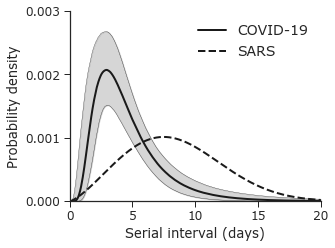

In [45]:
fig, ax = plt.subplots()
fig.set_size_inches(4.5,3.5); 

clrs = ['k','C7']

disease = 'COVID-19'
Ymedian = [np.median(yy[j]) for j in range(len(x)-1)]
Ylower = [np.percentile(yy[j],[2.5])[0] for j in range(len(x))]
Yupper = [np.percentile(yy[j],[97.5])[0] for j in range(len(x))]
ax.plot(x[1:], Ymedian, lw=2, color=clrs[0], label=disease)
ax.plot(x, Yupper, lw=.3, color=clrs[0])
ax.plot(x, Ylower, lw=.3, color=clrs[0])
ax.fill_between(x, Ylower, Yupper, color=clrs[1], alpha=.35)

ax.set_xlabel('Serial interval (days)'); ax.set_ylabel('Probability density')

disease = 'SARS'
res = fsolve(lambda x: find_params_Weibull(x, mean_SARS, sd_SARS), (1,1))
res_ = np.exp(res)
Y_SARS = [weibull_cdf(xx+xstep, res_[0], res_[1])-weibull_cdf(xx, res_[0], res_[1]) for xx in x]
ax.plot(x, Y_SARS, label=disease, lw=2, color=clrs[0], ls='dashed')

ax.legend(frameon=False)

ax.set_ylim(bottom=0, top=.003)
ax.set_xlim(0, 20)
ytks = [0,.001,.002,.003]; ax.set_yticks(ytks); 
ax.spines['left'].set_bounds(0,.003)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);

my_dpi = 300
plt.savefig("../../results/Fig-MAIN.pdf",
            format='pdf',
            figsize=(3.54331/my_dpi, 3.5/my_dpi), dpi=my_dpi,
            bbox_inches='tight');

# Location of the max and mean of the distribution

(for explanatory purposes)

Maximum (x): 2.93
Mean (--): 4.59


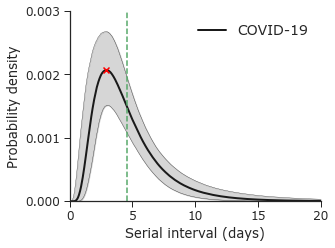

In [46]:
fig, ax = plt.subplots()
fig.set_size_inches(4.5,3.5); 

clrs = ['k', 'C7', 'C1']

disease = 'COVID-19'
Ymedian = [np.median(yy[j]) for j in range(len(x)-1)]
Ylower = [np.percentile(yy[j],[2.5])[0] for j in range(len(x))]
Yupper = [np.percentile(yy[j],[97.5])[0] for j in range(len(x))]
ax.plot(x[1:], Ymedian, lw=2, color=clrs[0], label=disease)
ax.plot(x, Yupper, lw=.3, color=clrs[0])
ax.plot(x, Ylower, lw=.3, color=clrs[0])
ax.fill_between(x, Ylower, Yupper, color=clrs[1], alpha=.35)

Ymean = [np.mean(yy[j]) for j in range(len(x)-1)]
Ymax_x = x[1:][np.argmax(Ymean)]
Ymax_y = Ymean[np.argmax(Ymean)]
print(colored("Maximum (x): %.2f"%x[1:][np.argmax(Ymean)],'red'))
ax.scatter([Ymax_x],[Ymax_y],color='red',marker='x',zorder=5)
Ymean_value = np.sum([x*y for x,y in zip(x[1:],Ymean)])
print(colored("Mean (--): %.2f"%Ymean_value,'green'))
ax.axvline(Ymean_value, color='C2', ls='dashed')

ax.set_xlabel('Serial interval (days)'); ax.set_ylabel('Probability density')

ax.legend(frameon=False)

ax.set_ylim(bottom=0, top=.003)
ax.set_xlim(0, 20)
ytks = [0,.001,.002,.003]; ax.set_yticks(ytks); 
ax.spines['left'].set_bounds(0,.003)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);

* Median can be calculated as $e^\mu$, where $\mu$ is the meanlog (param1 in our notation) of the lognormal distribution ([wikipedia](https://en.wikipedia.org/wiki/Log-normal_distribution)):

In [50]:
print(colored("Median: %.2f"%np.exp(np.mean(param1)),'blue'))

Median: 3.96


which coincides with the value stated in our paper.